## Assignment 3: Pattern Mining and Recommender Systems

### Task 2: Collaborative Filtering
### Lalitphan Sae-teoh, a1932456, Version 02

### Import Libraries

In [169]:
import pandas as pd
import numpy as np
from collections import defaultdict

import implicit
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Read Dataset

In [2]:
df = pd.read_csv('./data/Groceries data train.csv')
df.dropna(subset=["User_id"], inplace=True)
df = df.astype({'User_id': 'int', 'year': 'int', 'month': 'int', 'day': 'int', 'day_of_week': 'int'})
df['datetime'] = pd.to_datetime(df['Date'], dayfirst=True).dt.date
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
df.head()

,User_id,Date,itemDescription,year,month,day,day_of_week
datetime,,,,,,,
2014-01-01,2351,1/01/2014,cleaner,2014,1,1,2
2014-01-01,2226,1/01/2014,sausage,2014,1,1,2
2014-01-01,1922,1/01/2014,tropical fruit,2014,1,1,2
2014-01-01,2943,1/01/2014,whole milk,2014,1,1,2
2014-01-01,1249,1/01/2014,citrus fruit,2014,1,1,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19382 entries, 2014-01-01 to 2015-01-20
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_id          19382 non-null  int32 
 1   Date             19382 non-null  object
 2   itemDescription  19382 non-null  object
 3   year             19382 non-null  int32 
 4   month            19382 non-null  int32 
 5   day              19382 non-null  int32 
 6   day_of_week      19382 non-null  int32 
dtypes: int32(5), object(2)
memory usage: 832.8+ KB


In [4]:
df_test = pd.read_csv('./data/Groceries data test.csv')
df_test.rename(columns={"user_id": "User_id"}, inplace=True)
df_test.dropna(subset=["User_id"], inplace=True)
df_test = df_test.astype({'User_id': 'int', 'year': 'int', 'month': 'int', 'day': 'int', 'day_of_week': 'int'})
df_test['datetime'] = pd.to_datetime(df_test['Date'], dayfirst=True).dt.date
df_test.set_index('datetime', inplace=True)
df_test.sort_index(inplace=True)
df_test.head()

,User_id,Date,itemDescription,year,month,day,day_of_week
datetime,,,,,,,
2015-01-20,2889,20/01/2015,yogurt,2015,1,20,1
2015-01-20,4744,20/01/2015,soda,2015,1,20,1
2015-01-20,2430,20/01/2015,root vegetables,2015,1,20,1
2015-01-20,1492,20/01/2015,other vegetables,2015,1,20,1
2015-01-20,2682,20/01/2015,whole milk,2015,1,20,1


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19383 entries, 2015-01-20 to 2015-12-30
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_id          19383 non-null  int32 
 1   Date             19383 non-null  object
 2   itemDescription  19383 non-null  object
 3   year             19383 non-null  int32 
 4   month            19383 non-null  int32 
 5   day              19383 non-null  int32 
 6   day_of_week      19383 non-null  int32 
dtypes: int32(5), object(2)
memory usage: 832.9+ KB


Import frequent items rules

In [61]:
rules = pd.read_csv('./data/rules_dummy.csv')
print(f"Total Rules: {len(rules)}")
rules

Total Rules: 32


,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,19,frozenset({'frankfurter'}),frozenset({'whole milk'}),0.012199,0.130487,0.002033,0.166667,1.277269,1.0,0.000441,1.043416,0.219760,0.014456,0.041609,0.091124
1,17,frozenset({'detergent'}),frozenset({'rolls/buns'}),0.008492,0.101902,0.001196,0.140845,1.382166,1.0,0.000331,1.045328,0.278866,0.010953,0.043362,0.076291
2,29,frozenset({'seasonal products'}),frozenset({'rolls/buns'}),0.007774,0.101902,0.001076,0.138462,1.358776,1.0,0.000284,1.042436,0.266112,0.009912,0.040708,0.074512
3,24,frozenset({'pot plants'}),frozenset({'yogurt'}),0.008372,0.078579,0.001076,0.128571,1.636204,1.0,0.000419,1.057368,0.392112,0.012535,0.054256,0.071135
4,26,frozenset({'processed cheese'}),frozenset({'rolls/buns'}),0.011482,0.101902,0.001435,0.125000,1.226673,1.0,0.000265,1.026398,0.186933,0.012821,0.025719,0.069542
5,22,frozenset({'napkins'}),frozenset({'pastry'}),0.024997,0.049635,0.002033,0.081340,1.638750,1.0,0.000793,1.034512,0.399772,0.028007,0.033360,0.061152
6,4,frozenset({'sugar'}),frozenset({'bottled water'}),0.019376,0.060758,0.001555,0.080247,1.320757,1.0,0.000378,1.021189,0.247657,0.019787,0.020749,0.052919
7,11,frozenset({'cat food'}),frozenset({'fruit/vegetable juice'}),0.014233,0.036718,0.001076,0.075630,2.059754,1.0,0.000554,1.042096,0.521934,0.021583,0.040395,0.052473
8,1,frozenset({'berries'}),frozenset({'pastry'}),0.016266,0.049635,0.001196,0.073529,1.481396,1.0,0.000389,1.025791,0.330334,0.018484,0.025142,0.048813
9,31,frozenset({'sliced cheese'}),frozenset({'root vegetables'}),0.014711,0.060399,0.001076,0.073171,1.211447,1.0,0.000188,1.013780,0.177147,0.014540,0.013592,0.045496


In [72]:
def to_frozenset(x):
    clean_x = x.split("{")[1].split("}")[0].replace("'", "").split(",")
    return frozenset(clean_x)

rules["antecedents"] = rules["antecedents"].apply(to_frozenset)
rules["consequents"] = rules["consequents"].apply(to_frozenset)
rules.head()

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,19,(frankfurter),(whole milk),0.012199,0.130487,0.002033,0.166667,1.277269,1.0,0.000441,1.043416,0.219760,0.014456,0.041609,0.091124
1,17,(detergent),(rolls/buns),0.008492,0.101902,0.001196,0.140845,1.382166,1.0,0.000331,1.045328,0.278866,0.010953,0.043362,0.076291
2,29,(seasonal products),(rolls/buns),0.007774,0.101902,0.001076,0.138462,1.358776,1.0,0.000284,1.042436,0.266112,0.009912,0.040708,0.074512
3,24,(pot plants),(yogurt),0.008372,0.078579,0.001076,0.128571,1.636204,1.0,0.000419,1.057368,0.392112,0.012535,0.054256,0.071135
4,26,(processed cheese),(rolls/buns),0.011482,0.101902,0.001435,0.125000,1.226673,1.0,0.000265,1.026398,0.186933,0.012821,0.025719,0.069542


### Data Analysis

In [6]:

min_date = df.index.min()
max_date = df.index.max()
test_min_date = df_test.index.min()
test_max_date = df_test.index.max()

print("Train Dataset")
print("------------------------------------")
print(f"Total records: {len(df)}")
print("Minimum date:", min_date)
print("Maximum date:", max_date)
print("====================================")

print("Test Dataset")
print("------------------------------------")
print(f"Total records: {len(df_test)}")
print("Minimum date:", test_min_date)
print("Maximum date:", test_max_date)

Train Dataset
------------------------------------
Total records: 19382
Minimum date: 2014-01-01
Maximum date: 2015-01-20
Test Dataset
------------------------------------
Total records: 19383
Minimum date: 2015-01-20
Maximum date: 2015-12-30


In [7]:
users = df['User_id'].unique()
print("Total Train Users:", len(users))

test_users = df_test['User_id'].unique()
print("Total Test Users:", len(test_users))

set_train_users = set(users)
set_test_users = set(test_users)
all_users = set_train_users.union(set_test_users)

print(f"Total Unique Users in all data set: {len(all_users)}")

new_users_test_set = set_test_users.difference(set_train_users)
print(f"New users in test data set: {len(new_users_test_set)}")
print(f"Example of new test users: {list(new_users_test_set)[:5]}")

Total Train Users: 3493
Total Test Users: 3231
Total Unique Users in all data set: 3898
New users in test data set: 405
Example of new test users: [4102, 2061, 4118, 2073, 4141]


In [8]:
items = df['itemDescription'].unique()
print("Total:\n", len(items))
print("Items:\n", items[:50])

Total:
 167
Items:
 ['cleaner' 'sausage' 'tropical fruit' 'whole milk' 'citrus fruit' 'onions'
 'other vegetables' 'berries' 'hamburger meat' 'bottled water' 'butter'
 'yogurt' 'waffles' 'soda' 'sliced cheese' 'curd' 'specialty chocolate'
 'shopping bags' 'flower (seeds)' 'coffee' 'whipped/sour cream'
 'frozen potato products' 'candles' 'bottled beer' 'Instant food products'
 'frozen vegetables' 'brown bread' 'domestic eggs' 'dishes' 'chocolate'
 'pip fruit' 'frankfurter' 'sugar' 'beef' 'meat' 'root vegetables'
 'pastry' 'ice cream' 'rolls/buns' 'chicken' 'white bread' 'frozen fish'
 'sparkling wine' 'cream cheese ' 'fruit/vegetable juice' 'condensed milk'
 'soft cheese' 'canned beer' 'candy' 'dessert']


Visualization of Top 20 items

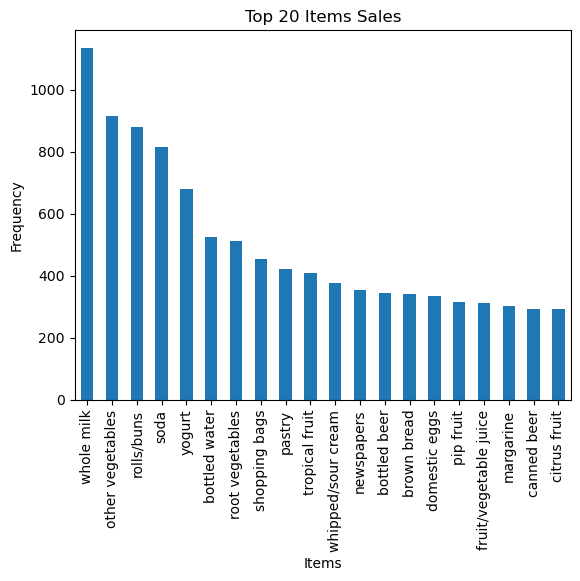

In [9]:
item_counts = df['itemDescription'].value_counts()[:20]

item_counts.plot.bar()
plt.title('Top 20 Items Sales')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.show()

Visualize Users Purchasing Distribution

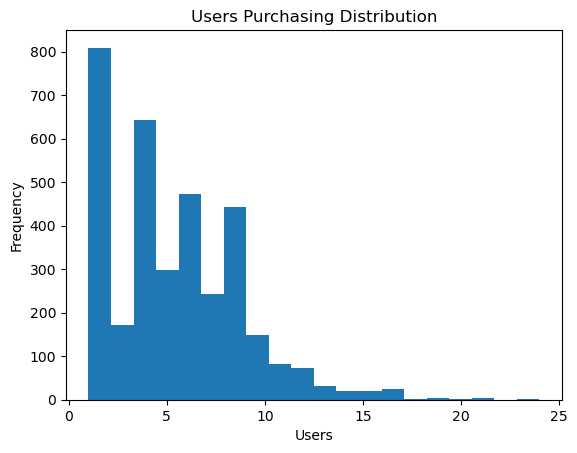

In [10]:
user_purchase_counts = df['User_id'].value_counts()

user_purchase_counts.hist(bins=20)
plt.title('Users Purchasing Distribution')
plt.xlabel('Users')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [11]:
# Top 20 users
user_purchase_counts[:10]

User_id
3247    24
4941    23
1410    21
1169    21
1466    21
3221    20
4272    20
4297    19
1004    19
4683    19
Name: count, dtype: int64

Find average items (total items & unique items) sales / users - for users threshold

In [12]:
df_items_per_users_count = df.groupby('User_id').agg({"itemDescription": ["nunique"]}).reset_index()
df_items_per_users_count.columns = ['User_id', 'unique_items_count']
df_items_per_users_count.head()

,User_id,unique_items_count
0,1000,3
1,1001,5
2,1002,4
3,1003,5
4,1004,15


In [13]:
total_unique_items_sales = df_items_per_users_count['unique_items_count'].sum()
total_users = df_items_per_users_count['User_id'].count()

avg_items_sales_per_user = total_unique_items_sales / total_users
print("Total Users: ", total_users)
print("Total Unique Items Sales: ", total_unique_items_sales)
print(f"Average unique items per user: {avg_items_sales_per_user:.2f}")

Total Users:  3493
Total Unique Items Sales:  18288
Average unique items per user: 5.24


Find popularity of item - average users / items

In [14]:
df_users_per_items_count = df.groupby('itemDescription').agg({"User_id": ["nunique"]}).reset_index()
df_users_per_items_count.columns = ['itemDescription', 'unique_users_count']
df_users_per_items_count.head()

,itemDescription,unique_users_count
0,Instant food products,37
1,UHT-milk,165
2,abrasive cleaner,12
3,artif. sweetener,14
4,baby cosmetics,1


In [15]:
total_users_bought = df_users_per_items_count['unique_users_count'].sum()
total_items = df_users_per_items_count['itemDescription'].count()

avg_users_per_item = total_users_bought / total_items
print("Total Items: ", total_items)
print("Total Users Bought: ", total_users_bought)
print(f"Average unique users per item: {avg_users_per_item:.2f}")

Total Items:  167
Total Users Bought:  18288
Average unique users per item: 109.51


### Data Preprocessing

In [16]:
df_user_items = df.groupby(['User_id', 'itemDescription']).agg({'Date':['count']}).reset_index()
df_user_items.columns = ['User_id', 'itemDescription', 'frequency']
df_user_items.head()

,User_id,itemDescription,frequency
0,1000,pastry,1
1,1000,salty snack,1
2,1000,whole milk,1
3,1001,frankfurter,1
4,1001,rolls/buns,1


In [148]:
# decay_days = (max_date - min_date).days
# print(decay_days)

df['days_ago'] = (max_date - df.index)
df['days_ago'] = df['days_ago'].dt.components.days
# 120 buying patterns over 4 months
df['recency_weight'] = np.exp(-df['days_ago'] / 120)
df.head()

,User_id,Date,itemDescription,year,month,day,day_of_week,days_ago,recency_weight
datetime,,,,,,,,,
2014-01-01,2351,1/01/2014,cleaner,2014,1,1,2,384,0.040762
2014-01-01,2226,1/01/2014,sausage,2014,1,1,2,384,0.040762
2014-01-01,1922,1/01/2014,tropical fruit,2014,1,1,2,384,0.040762
2014-01-01,2943,1/01/2014,whole milk,2014,1,1,2,384,0.040762
2014-01-01,1249,1/01/2014,citrus fruit,2014,1,1,2,384,0.040762


In [149]:
# Sum weighted counts per user-item
weighted_df = df.groupby(['User_id', 'itemDescription'])['recency_weight'].sum().reset_index()

# Option 1: Multiply frequency × mean recency weight per user-item
df_user_items_recency = df_user_items.merge(weighted_df, on=['User_id', 'itemDescription'])
df_user_items_recency['final_weight'] = df_user_items_recency['frequency'] * df_user_items_recency['recency_weight']
df_user_items_recency

,User_id,itemDescription,frequency,recency_weight,final_weight
0,1000,pastry,1,0.173774,0.173774
1,1000,salty snack,1,0.173774,0.173774
2,1000,whole milk,1,0.173774,0.173774
3,1001,frankfurter,1,1.000000,1.000000
4,1001,rolls/buns,1,0.185754,0.185754
...,...,...,...,...,...
18283,4999,semi-finished bread,1,0.316637,0.316637
18284,5000,bottled beer,1,0.581778,0.581778
18285,5000,fruit/vegetable juice,1,0.314009,0.314009
18286,5000,onions,1,0.314009,0.314009


As our dataset is implicit feedback, it would be logical to assign values to every variable. It is set to 0 when there isn't a purchase on record.

In [150]:
user_items_matrix = df_user_items_recency.pivot(index="User_id", columns="itemDescription", values="final_weight")
user_items_matrix.fillna(0, inplace=True)
user_items_matrix

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
User_id,,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173774,0.0,0.0
1001,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.816562,0.0,0.0
1002,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106281,0.0,0.0
1003,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1004,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.407088,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.0,0.0,0.268027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4995,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4997,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110803,0.0,0.0


In [151]:
sparse_matrix = csr_matrix(user_items_matrix.values)
print(sparse_matrix[:3])

  (0, 105)	0.17377394345044514
  (0, 128)	0.17377394345044514
  (0, 164)	0.17377394345044514
  (1, 56)	1.0
  (1, 122)	0.18575376371409136
  (1, 130)	0.18575376371409136
  (1, 138)	3.4450547072841444
  (1, 164)	1.8165622347123271
  (2, 15)	0.1062812213155449
  (2, 63)	0.3114032239145977
  (2, 102)	0.3114032239145977
  (2, 164)	0.1062812213155449


### Model Implementation

In [170]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

weighted_matrix = bm25_weight(sparse_matrix.T).T

model = AlternatingLeastSquares(factors=50, regularization=0.2, iterations=20, random_state=8)
model.fit(weighted_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [167]:
user_mapping = list(user_items_matrix.index)
item_mapping = list(user_items_matrix.columns)

In [182]:
def recommend_without_freqset(user_items_matrix, user_id, user_mapping=user_mapping, item_mapping=item_mapping, number_of_items=5):

    # user_id index
    user_index = user_mapping.index(user_id)
    recommended = model.recommend(user_index, sparse_matrix[user_index], N=number_of_items)
    # recommended = (array(item), array(score))
    recommended_items = [item_mapping[item_id] for item_id in recommended[0]]
    recommended_score = recommended[1]

    print(f"Item - Score")
    for index, item_name in enumerate(recommended_items):
        print(f"{item_name}: {recommended_score[index]}")

    return recommended_items

In [180]:
def recommend_with_freqset(user_items_matrix, user_id, rules=rules, user_mapping=user_mapping, item_mapping=item_mapping, number_of_items=5):
    # Get items the user recently interacted with
    user_purchased_items = set(df[df['User_id'] == user_id]['itemDescription'].unique().tolist())
    rule_boost = defaultdict(float)
    for _, row in rules.iterrows():
        if set(row['antecedents']).issubset(set(user_purchased_items)):
            for item in row['consequents']:
                rule_boost[item] += row['lift']  # or use confidence
    user_index = user_mapping.index(user_id)

    # top_item can be changed
    top_item=20
    recommended = model.recommend(user_index, sparse_matrix[user_index], N=top_item)
    recommended_top_items = [(item_id, item_mapping[item_id]) for item_id in recommended[0]]
    recommended_score = recommended[1]
    
    final_scores = {}
    for index, item in enumerate(recommended_top_items):
        item_name = item[1]
        boost = rule_boost.get(item_name, 0)
        final_scores[item_name] = recommended_score[index] + boost  # tune this weight if needed

    final_recommendations = sorted(final_scores.items(), key=lambda x: -x[1])[:5]
    final_recommendation_items = []
    print(f"Item - Score")
    for item_name, score in final_recommendations:
        print(f"{item_name}: {score}")
        final_recommendation_items.append(item_name)

    return final_recommendation_items

### Evaluation

In [173]:
df[df["User_id"] == 2430]

,User_id,Date,itemDescription,year,month,day,day_of_week,days_ago,recency_weight
datetime,,,,,,,,,
2014-01-28,2430,28/01/2014,pastry,2014,1,28,1,357,0.051047
2014-01-28,2430,28/01/2014,margarine,2014,1,28,1,357,0.051047
2014-01-28,2430,28/01/2014,pastry,2014,1,28,1,357,0.051047
2014-01-28,2430,28/01/2014,pastry,2014,1,28,1,357,0.051047
2014-03-02,2430,2/03/2014,sausage,2014,3,2,6,324,0.067206
2014-03-02,2430,2/03/2014,pastry,2014,3,2,6,324,0.067206
2015-01-20,2430,20/01/2015,fruit/vegetable juice,2015,1,20,1,0,1.000000
2015-01-20,2430,20/01/2015,specialty bar,2015,1,20,1,0,1.000000


In [174]:
df_test[df_test["User_id"] == 2430]

,User_id,Date,itemDescription,year,month,day,day_of_week
datetime,,,,,,,
2015-01-20,2430,20/01/2015,root vegetables,2015,1,20,1
2015-01-20,2430,20/01/2015,sliced cheese,2015,1,20,1
2015-01-20,2430,20/01/2015,butter,2015,1,20,1
2015-01-20,2430,20/01/2015,chocolate,2015,1,20,1


In [183]:
print(recommend_without_freqset(user_items_matrix, 2430))

Item - Score
spread cheese: 0.20010928809642792
sliced cheese: 0.18335169553756714
pet care: 0.18330147862434387
liver loaf: 0.17410671710968018
cling film/bags: 0.16836507618427277
['spread cheese', 'sliced cheese', 'pet care', 'liver loaf', 'cling film/bags']


In [181]:
print(recommend_with_freqset(user_items_matrix, 2430))

Item - Score
cat food: 2.2099005451020934
spread cheese: 0.20010928809642792
sliced cheese: 0.18335169553756714
pet care: 0.18330147862434387
liver loaf: 0.17410671710968018
['cat food', 'spread cheese', 'sliced cheese', 'pet care', 'liver loaf']


### Reflection

**Code Version**: version01

* **Stages**: Analyst, Visualized data, Preprocessed data and Implemented base model
* **Progress & Results**: Performed analysis, reseach collaborative filtering methods and implement the first base model.
* **Reflection**: I learned how to analyze transaction data. During data preprocessing, I found that the user-item matrix had many missing values, so I researched the method of handling them. As the dataset is implicit feedback, the missing value can be treated as zero to indicate that there is zero purchasing on that item (Yifan Hu, Koren, Y & Volinsky, C 2008). The first base model used the AlternatingLeastSquares approach.

**Code Version**: version02

* **Stages**: Implemented recommendation model
* **Progress & Results**: Implemented collaborative filtering with frequency dataset and added recency weight. 
* **Reflection**: One of the assignment requirements indicates that the recommendation items should based on the recency of users purchased. Therefore, I added the recency weight and multiplied it by the quantity for the Users-Items matrix, which will be input for the collaborative filtering model. Then, I learned how to integrate association rules into collaborative filtering. The rules in this code version are dummy, so I couldn't compare the results with/without frequency datasets. I also cleaned the code to function that makes it easier to integrate in task3.

**Summarize Progress Table** 

| Code Version | Progress & Results                                                                         |
|:-------------|:-------------------------------------------------------------------------------------------|
|version01     |Performed analysis, reseach collaborative filtering methods and implement the first base model.|
|version02     |Implemented collaborative filtering with frequency dataset and added recency weight.|


### References

| Contribution Part | Reference                  |Citation                                                  |
|:------------------|:---------------------------|:---------------------------------------------------------|
|Data Preprocessing|Users & Items Matrix|Zaishan Weng 2023, 'Quick start guide to build a Collaborative Filtering Recommendation System with implicit library in 4 steps', medium, accessed 23 April 2025,<https://medium.com/@zaishanweng/quick-start-guide-to-build-a-collaborative-filtering-recommendation-system-with-implicit-library-in-c5e79e35dfb8>|
|Data Preprocessing|Data Sparse|Yuki Shizuya 2024, 'Detailed explanation about Collaborative filtering with Python examples', medium, accessed 23 April 2025,<https://medium.com/@ichigo.v.gen12/detailed-explanation-about-collaborative-filtering-eab116e3b28b>|
|Model Implementation|Implicit feedback|Yao-Ting(Teddy) 2019,'Implicit Feedback Recommendation System (II) — Collaborative Filtering', medium, accessed 23 April 2025,<https://medium.com/@teddywang0202/implicit-feedback-recommendation-system-ii-collaborative-filtering-27be600197f1>|
|Model Implementation|Implicit feedback|Yifan Hu, Koren, Y & Volinsky, C 2008, ‘Collaborative Filtering for Implicit Feedback Datasets’, in 2008 Eighth IEEE International Conference on Data Mining, IEEE, pp. 263–272.|
|Model Implementation|Implicit Library|implicit library, https://benfred.github.io/implicit/index.html|
|Model Implementation|OpenAI ChatGPT|OpenAI’s ChatGPT, personal communication, <https://chatgpt.com/>|
|Model Implementation|Association Rules Integration|Lee, C.H., Kim, Y.H. and Rhee, P.K., 2001. Web personalization expert with combining collaborative filtering and association rule mining technique. Expert Systems with Applications, 21(3), pp.131-137.|
|Model Implementation|Association Rules Integration|Parvatikar, S. and Joshi, B., 2015, December. Online book recommendation system by using collaborative filtering and association mining. In 2015 IEEE International Conference on Computational Intelligence and Computing Research (ICCIC) (pp. 1-4).|